<a href="https://colab.research.google.com/github/jdchen5/machinelearninglabs/blob/main/W22/requiredActivity22-3-JC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!pip install scikit-learn

In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the dataset
data_dir = '/content/gdrive/My Drive/Pythoncode/W22/faces_4'
# Get all class directories
class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

print(class_dirs)

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# Split each class's files and move them to the corresponding train/test directories
for class_dir in class_dirs:
    # Full path to the class directory
    class_path = os.path.join(data_dir, class_dir)
    # Get all files in the class directory
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Check if there are any files to split
    if not files:
        print(f"No files to split in directory {class_dir}. Skipping...")
        continue

    # Split the files into 80% train and 20% test
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    # Create corresponding class directories in train and test directories
    train_class_dir = os.path.join(train_dir, class_dir)
    test_class_dir = os.path.join(test_dir, class_dir)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Function to copy files to the specified directory
    def copy_files(files, source_dir, destination_dir):
        for file in files:
            shutil.copy(os.path.join(source_dir, file), os.path.join(destination_dir, file))

    # Copy the files to their respective directories
    copy_files(train_files, class_path, train_class_dir)
    copy_files(test_files, class_path, test_class_dir)

print("Data split into train and test directories.")

['choon', 'ch4f', 'karyadi', 'bpm', 'an2i', 'glickman', 'at33', 'danieln', 'boland', 'cheyer', 'night', 'saavik', 'mitchell', 'kk49', 'steffi', 'kawamura', 'megak', 'sz24', 'phoebe', 'tammo']
Data split into train and test directories.


In [43]:
%matplotlib inline

In [104]:
from __future__ import print_function

import argparse
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm

from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision.datasets.folder import default_loader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [105]:
import cv2
img = cv2.imread("some_image.pgm", cv2.IMREAD_COLOR)

In [106]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [107]:
# Custom helper function to load images in PGM format using OpenCV
def img_loader(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

data = ImageFolder(root='/content/gdrive/My Drive/Pythoncode/W22/faces_4/', loader=img_loader, transform=transforms)
data.classes



['an2i',
 'at33',
 'boland',
 'bpm',
 'ch4f',
 'cheyer',
 'choon',
 'danieln',
 'glickman',
 'karyadi',
 'kawamura',
 'kk49',
 'megak',
 'mitchell',
 'night',
 'phoebe',
 'saavik',
 'steffi',
 'sz24',
 'tammo',
 'test',
 'train']

In [108]:
# Get some random dataset  images

def show_test_images(transform, test_dataset, test_loader):
    # Get some random test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Show images
    imshow(torchvision.utils.make_grid(images))

    # Get the class names from the 'test_dataset'
    class_names = test_dataset.classes

    # Print labels with class names
    print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in labels))


In [109]:
# Define a CNN architecture inspired by LeNet5, adjusted for binary classification
class Net(nn.Module):
    def __init__(self, num_classes):  # Take num_classes as an argument
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # Adjusted for multi-class classification

        # compute the total number of parameters
        #total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        #print(self.name + ': total params:', total_params)

    def forward(self, x):

        #print(f"MitchellNet Input batch size: {x.size(0)}")  # Should always be 64 based on your DataLoader

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))

        #print(x.size())  # Add this line to check the size of the output here

        #x = x.view(-1, 16 * 4 * 5)
        # Dynamically calculate the size
        size = x.size()[1:]  # Get the shape except for the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        x = x.view(-1, num_features)  # Use the dynamically calculated size

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        #print(f"Input batch size: {x.size(0)}")  # Should be 64
        #print(f"Output batch size: {x.size(0)}")  # Should also be 64

        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features




In [110]:
# Define a function to reset the model
def reset_model(num_classes, device):
    model = Net(num_classes=num_classes).to(device)
    return model

# Define a function to reset the optimizer
def reset_optimizer(model, lr=0.01, momentum=0.9):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    return optimizer

In [111]:


# Training function
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval=10):
    model.train()
    train_loss = 0.0
    total_batches = len(train_loader.dataset) // train_loader.batch_size
    for i, data in enumerate(train_loader, 1):  # Start enumeration from 1 for printing purposes
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(f"Batch {i}, Input size: {inputs.size()}, Labels size: {labels.size()}")  # Debug print
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        #loss = F.nll_loss(outputs, labels)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
        # Print every log_interval mini-batches
        if i % log_interval == 0 or i == total_batches:  # Also log on the last batch
            print(f'[{epoch}, {i:5d}] loss: {train_loss / log_interval:.3f}')
            train_loss = 0.0


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(len(test_loader.dataset.classes)))
    class_total = list(0. for i in range(len(test_loader.dataset.classes)))

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()  # Fixed line here
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Collect the correct predictions for each class
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):  # Loop over the batch
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Calculate and print average loss and total accuracy
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

    # Print accuracy for each class
    for i in range(len(test_loader.dataset.classes)):
        print('Accuracy of %5s : %2d %%' % (
            test_loader.dataset.classes[i], 100 * class_correct[i] / class_total[i] if class_total[i] else 0))


args.data= /content/gdrive/My Drive/Pythoncode/W22/faces_4


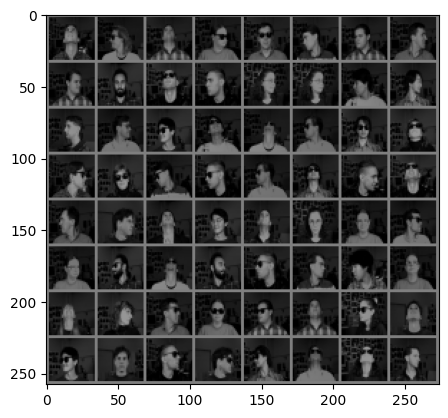

GroundTruth:  choon karyadi karyadi mitchell saavik cheyer karyadi saavik karyadi mitchell  kk49  kk49 boland boland danieln  kk49 night  ch4f night danieln karyadi  ch4f  kk49   bpm choon   bpm cheyer  kk49  ch4f  kk49  kk49  kk49 saavik night saavik night night boland mitchell tammo mitchell mitchell karyadi mitchell  kk49 cheyer  sz24 mitchell kawamura   bpm saavik mitchell karyadi karyadi boland night night night  kk49 night  kk49  ch4f boland night
Starting training session 0/3
[1,     7] loss: 0.068
[2,     7] loss: 0.096
[3,     7] loss: 0.072
[4,     7] loss: 0.062
[5,     7] loss: 0.066
[6,     7] loss: 0.064
[7,     7] loss: 0.063
[8,     7] loss: 0.054
[9,     7] loss: 0.048
[10,     7] loss: 0.015



Test set: Average loss: 0.0389, Accuracy: 135/136 (99%)
Accuracy of  an2i : 100 %
Accuracy of  at33 : 100 %
Accuracy of boland : 100 %
Accuracy of   bpm : 100 %
Accuracy of  ch4f : 100 %
Accuracy of cheyer : 100 %
Accuracy of choon : 100 %
Accuracy of danieln : 100 %
Accuracy of glickman : 100 %
Accuracy of karyadi : 100 %
Accuracy of kawamura : 100 %
Accuracy of  kk49 : 100 %
Accuracy of megak : 100 %
Accuracy of mitchell : 100 %
Accuracy of night : 100 %
Accuracy of phoebe : 100 %
Accuracy of saavik : 100 %
Accuracy of steffi : 100 %
Accuracy of  sz24 : 85 %
Accuracy of tammo : 100 %
Starting training session 1/3
[1,     7] loss: 0.011
[2,     7] loss: 0.008
[3,     7] loss: 0.006
[4,     7] loss: 0.004
[5,     7] loss: 0.003
[6,     7] loss: 0.002
[7,     7] loss: 0.003
[8,     7] loss: 0.002
[9,     7] loss: 0.002
[10,     7] loss: 0.002



Test set: Average loss: 0.0453, Accuracy: 135/136 (99%)
Accuracy of  an2i : 100 %
Accuracy of  at33 : 100 %
Accuracy of boland : 100 %
Accuracy of   bpm : 100 %
Accuracy of  ch4f : 100 %
Accuracy of cheyer : 100 %
Accuracy of choon : 100 %
Accuracy of danieln : 100 %
Accuracy of glickman : 100 %
Accuracy of karyadi : 100 %
Accuracy of kawamura : 100 %
Accuracy of  kk49 : 100 %
Accuracy of megak : 100 %
Accuracy of mitchell : 100 %
Accuracy of night : 100 %
Accuracy of phoebe : 100 %
Accuracy of saavik : 100 %
Accuracy of steffi : 100 %
Accuracy of  sz24 : 85 %
Accuracy of tammo : 100 %
Starting training session 2/3
[1,     7] loss: 0.002
[2,     7] loss: 0.002
[3,     7] loss: 0.002
[4,     7] loss: 0.002
[5,     7] loss: 0.001
[6,     7] loss: 0.001
[7,     7] loss: 0.001
[8,     7] loss: 0.001
[9,     7] loss: 0.001
[10,     7] loss: 0.001



Test set: Average loss: 0.0479, Accuracy: 135/136 (99%)
Accuracy of  an2i : 100 %
Accuracy of  at33 : 100 %
Accuracy of boland : 100 %
Accuracy of   bpm : 100 %
Accuracy of  ch4f : 100 %
Accuracy of cheyer : 100 %
Accuracy of choon : 100 %
Accuracy of danieln : 100 %
Accuracy of glickman : 100 %
Accuracy of karyadi : 100 %
Accuracy of kawamura : 100 %
Accuracy of  kk49 : 100 %
Accuracy of megak : 100 %
Accuracy of mitchell : 100 %
Accuracy of night : 100 %
Accuracy of phoebe : 100 %
Accuracy of saavik : 100 %
Accuracy of steffi : 100 %
Accuracy of  sz24 : 85 %
Accuracy of tammo : 100 %
Finished Training
training time  97.17845416069031


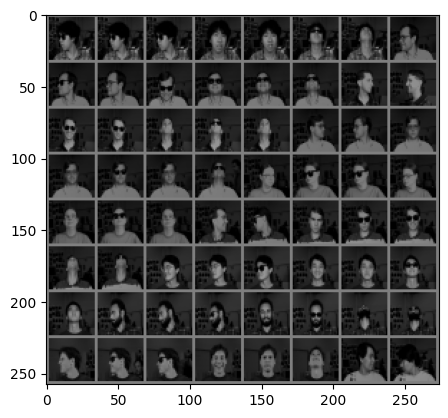

GroundTruth:   an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  an2i  at33  at33  at33  at33  at33  at33  at33  at33  at33  at33  at33  at33  at33  at33  at33



Test set: Average loss: 0.0479, Accuracy: 135/136 (99%)
Accuracy of  an2i : 100 %
Accuracy of  at33 : 100 %
Accuracy of boland : 100 %
Accuracy of   bpm : 100 %
Accuracy of  ch4f : 100 %
Accuracy of cheyer : 100 %
Accuracy of choon : 100 %
Accuracy of danieln : 100 %
Accuracy of glickman : 100 %
Accuracy of karyadi : 100 %
Accuracy of kawamura : 100 %
Accuracy of  kk49 : 100 %
Accuracy of megak : 100 %
Accuracy of mitchell : 100 %
Accuracy of night : 100 %
Accuracy of phoebe : 100 %
Accuracy of saavik : 100 %
Accuracy of steffi : 100 %
Accuracy of  sz24 : 85 %
Accuracy of tammo : 100 %


In [112]:
import sys
import time


def main(args=None):
    if args is None:
        # When the script is run in a Jupyter notebook, ignore the command-line arguments
        args = sys.argv[1:]
        args = [arg for arg in args if not arg.startswith('-f')]

    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch Faces Classifier Training')
    parser.add_argument('--data', type=str, default='/content/gdrive/My Drive/Pythoncode/W22/faces_4', metavar='N',
                        help='Path to directory containing faces dataset.')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')


    # Parse only the known arguments and ignore the rest
    args, unknown = parser.parse_known_args(args)

    print(f"args.data= {args.data}")


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load datasets
    train_dataset = ImageFolder(root=os.path.join(args.data, 'train'), loader=img_loader, transform=transform)
    num_classes_train = len(train_dataset.classes)  # Determine the number of classes dynamically
    test_dataset = ImageFolder(root=os.path.join(args.data, 'test'), loader=img_loader, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    num_training_sessions = 3  # Define the number of training sessions

    criterion = nn.CrossEntropyLoss()
    model = reset_model(num_classes_train, device)
    optimizer = reset_optimizer(model, lr=args.lr, momentum=args.momentum)

    show_test_images(transform, train_dataset, train_loader)

    start = time.time()
    model_path = '/content/gdrive/My Drive/Pythoncode/W22/model.pth'

    # Check if a pre-trained model exists
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    for session in range(num_training_sessions):
        print(f"Starting training session {session}/{num_training_sessions}")

        for epoch in range(1, args.epochs + 1):
            train(model, device, train_loader, optimizer,  criterion, epoch)

        test(model, device, test_loader, criterion)
        # Save the model after each epoch
        torch.save(model.state_dict(), model_path)




    print('Finished Training')
    end = time.time()
    print('training time ', end-start)

    show_test_images(transform, test_dataset, test_loader)
    test(model, device, test_loader, criterion)

if __name__ == '__main__':
    main()


In [116]:
from PIL import Image

# Define a custom function to load a PGM image using OpenCV and convert it to a PIL Image
def load_pgm_to_pil(path):
    # Load PGM image as grayscale
    image_cv = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Convert to PIL Image
    image_pil = Image.fromarray(image_cv)
    return image_pil

# Classes your model was trained on
classes = ['an2i',
 'at33',
 'boland',
 'bpm',
 'ch4f',
 'cheyer',
 'choon',
 'danieln',
 'glickman',
 'karyadi',
 'kawamura',
 'kk49',
 'megak',
 'mitchell',
 'night',
 'phoebe',
 'saavik',
 'steffi',
 'sz24',
 'tammo']  # Add or adjust according to your classes

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load the trained model
model_path = '/content/gdrive/My Drive/Pythoncode/W22/model.pth'
# Define the number of classes as per your training setup
num_classes = 20  # Adjust this based on your actual number of classes
model = reset_model(num_classes, device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare the image
image_path = '/content/gdrive/My Drive/Pythoncode/W22/faces_4/mitchell/mitchell_up_sad_sunglasses_4.pgm'
image = load_pgm_to_pil(image_path)

# Modify your transformations for a single channel
transform = transforms.Compose([
    #transforms.Resize((32, 32)),  # Resize to match your model input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization for a single channel
])

image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

# Classify the image whether it is mitchell
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = classes[predicted.item()]

# Interpret the result
print(f"Predicted class: {predicted_class}")
if "mitchell" in predicted_class.lower():
    print("This image is a picture of Mitchell.")
else:
    print("This image is not a picture of Mitchell.")


# Predict the facial expression
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    predicted_expression_index = predicted.item()
    # Assuming 'expressions' is a list of expression names in the same order as during training
    predicted_expression = expressions[predicted_expression_index]
    print(f"Predicted facial expression: {predicted_expression}")

Predicted class: mitchell
This image is a picture of Mitchell.


NameError: name 'expressions' is not defined

In [115]:
from PIL import Image

# Define a custom function to load a PGM image using OpenCV and convert it to a PIL Image
def load_pgm_to_pil(path):
    # Load PGM image as grayscale
    image_cv = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Convert to PIL Image
    image_pil = Image.fromarray(image_cv)
    return image_pil

# Classes your model was trained on
classes = ['an2i',
 'at33',
 'boland',
 'bpm',
 'ch4f',
 'cheyer',
 'choon',
 'danieln',
 'glickman',
 'karyadi',
 'kawamura',
 'kk49',
 'megak',
 'mitchell',
 'night',
 'phoebe',
 'saavik',
 'steffi',
 'sz24',
 'tammo']  # Add or adjust according to your classes

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load the trained model
model_path = '/content/gdrive/My Drive/Pythoncode/W22/model.pth'
# Define the number of classes as per your training setup
num_classes = 20  # Adjust this based on your actual number of classes
model = reset_model(num_classes, device)

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare the image
image_path = '/content/gdrive/My Drive/Pythoncode/W22/faces_4/bpm/bpm_up_sad_sunglasses_4.pgm'
image = load_pgm_to_pil(image_path)

# Modify your transformations for a single channel
transform = transforms.Compose([
    #transforms.Resize((32, 32)),  # Resize to match your model input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization for a single channel
])

image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

# Classify the image
with torch.no_grad():
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = classes[predicted.item()]

# Interpret the result
print(f"Predicted class: {predicted_class}")
if "mitchell" in predicted_class.lower():
    print("This image is a picture of Mitchell.")
else:
    print("This image is not a picture of Mitchell.")

Predicted class: bpm
This image is not a picture of Mitchell.
